Epoch: 1 VAE Loss: 13685.9814453125 GAN D Loss: 0.037099361419677734 GAN G Loss: 6.884972095489502
Epoch: 2 VAE Loss: 12590.515625 GAN D Loss: 0.25339868664741516 GAN G Loss: 6.742323398590088
Epoch: 3 VAE Loss: 11979.5029296875 GAN D Loss: 0.3415181040763855 GAN G Loss: 4.9124531745910645
Epoch: 4 VAE Loss: 10800.509765625 GAN D Loss: 0.2366768717765808 GAN G Loss: 6.602697849273682
Epoch: 5 VAE Loss: 10792.681640625 GAN D Loss: 0.18845731019973755 GAN G Loss: 3.938040018081665


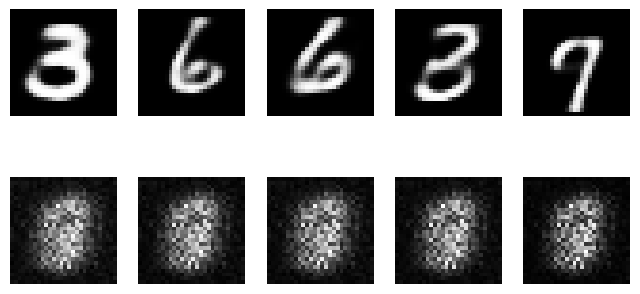

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

vae_transform = transforms.ToTensor()

gan_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

vae_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=vae_transform,
    download=True
)

gan_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=gan_transform,
    download=True
)

vae_loader = DataLoader(vae_dataset, batch_size=128, shuffle=True)
gan_loader = DataLoader(gan_dataset, batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc_mu = nn.Linear(256, 64)
        self.fc_logvar = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h = torch.relu(self.fc2(z))
        out = torch.sigmoid(self.fc3(h))
        return out, mu, logvar

class GANGenerator(nn.Module):
    def __init__(self, noise_dim=100):
        super(GANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

vae = VAE()
generator = GANGenerator()
discriminator = GANDiscriminator()

vae_optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

bce = nn.BCELoss()

def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

epochs = 5
noise_dim = 100

for epoch in range(epochs):

    vae_iter = iter(vae_loader)
    gan_iter = iter(gan_loader)

    for _ in range(len(vae_loader)):

        vae_imgs, _ = next(vae_iter)
        gan_imgs, _ = next(gan_iter)

        vae_imgs = vae_imgs.view(vae_imgs.size(0), -1)
        gan_imgs = gan_imgs.view(gan_imgs.size(0), -1)

        recon, mu, logvar = vae(vae_imgs)
        v_loss = vae_loss(recon, vae_imgs, mu, logvar)

        vae_optimizer.zero_grad()
        v_loss.backward()
        vae_optimizer.step()

        real_labels = torch.ones(gan_imgs.size(0), 1)
        fake_labels = torch.zeros(gan_imgs.size(0), 1)

        noise = torch.randn(gan_imgs.size(0), noise_dim)
        fake_imgs = generator(noise)

        real_out = discriminator(gan_imgs)
        fake_out = discriminator(fake_imgs.detach())

        d_loss = bce(real_out, real_labels) + bce(fake_out, fake_labels)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        fake_out = discriminator(fake_imgs)
        g_loss = bce(fake_out, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print("Epoch:", epoch+1, "VAE Loss:", v_loss.item(), "GAN D Loss:", d_loss.item(), "GAN G Loss:", g_loss.item())

vae_samples, _ = next(iter(vae_loader))
vae_samples = vae_samples.view(vae_samples.size(0), -1)

vae_recon, _, _ = vae(vae_samples)

noise = torch.randn(10, noise_dim)
gan_generated = generator(noise)

vae_recon = vae_recon.detach().numpy()
gan_generated = gan_generated.detach().numpy()

plt.figure(figsize=(8,4))

for i in range(5):

    plt.subplot(2,5,i+1)
    plt.imshow(vae_recon[i].reshape(28,28), cmap='gray')
    plt.axis('off')

    plt.subplot(2,5,i+6)
    plt.imshow(gan_generated[i].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.show()
